In [1]:
import numpy as np
import pandas as pd
import pydicom
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M


In [3]:
def seed_everything(seed=2020):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
seed_everything(42)

In [4]:
ROOT = "../input/osic-pulmonary-fibrosis-progression"
BATCH_SIZE=128

In [5]:
train_df = pd.read_csv(f"{ROOT}/train.csv")
# train_df['Where'] = 'train'
test_df = pd.read_csv(f"{ROOT}/test.csv")
# test_df['Where'] = 'test'
# data = train_df.append(test_df)


In [6]:
#Normalization
# data['Age'] = (data['Age'] - train_df['Age'].min() ) / ( train_df['Age'].max() - train_df['Age'].min() )
# data['FVC'] = (data['FVC'] - train_df['FVC'].min() ) / ( train_df['FVC'].max() - train_df['FVC'].min() )
# data['Percent'] = (data['Percent'] - train_df['Percent'].min() ) / ( train_df['Percent'].max() - train_df['Percent'].min() )
# data['Weeks'] = (data['Weeks'] - train_df['Weeks'].min() ) / ( train_df['Weeks'].max() - train_df['Weeks'].min() )
# data['FVC'] = (data['FVC'] - train_df['FVC'].min() ) / ( train_df['FVC'].max() - train_df['FVC'].min() )
# data.head()

In [7]:
def rebase_weeks(data, mode = "random"):
    
    # we rebased weeks w.r.t. a random week
#     data['base_week'] = data.groupby('Patient')['Weeks'].transform('min') #minimal week that we have for each patient
    
    data['max_week'] = data.groupby('Patient')['Weeks'].transform('max')
    data['min_week'] = data.groupby('Patient')['Weeks'].transform('min')
    base_week_df = data[['Patient', 'min_week', 'max_week']].copy()
    base_week_df.drop_duplicates(inplace = True)
    
    if mode == "min":
        base_week_df['base_week'] = base_week_df['min_week']
    elif mode == "random": 
        base_week_df['base_week'] =  base_week_df.apply(lambda x:np.random.randint(x['min_week'],np.round(x['max_week']+x['min_week'])/2), axis = 1 )
        
    data = data.merge(base_week_df[["Patient", "base_week"]], on="Patient")
    data['DeltaWeeks'] = data['Weeks'] - data['base_week'] 
    data.drop(["base_week", "min_week", "max_week"], axis=1, inplace=True)
    
    # we add column DeltaFVC to capture the FVC change from the first week and all other weeks (i.e. the slope)
    FVC_df=data[data['DeltaWeeks'] == 0][['Patient', 'FVC']] #FVC taken at the minimal week for each patient: FVC_0
    FVC_df.columns = ["Patient", "FVC_0"]
    data = data.merge(FVC_df, on="Patient")
    
    return data

In [8]:
#Normalization and one-hot encoding
def normalize_patients(data):
    min_age = 50
    max_age = 90
    data['Age'] = (data['Age'] - min_age ) / ( max_age - min_age )
    min_FVC = 1000
    max_FVC = 6500
    data['FVC_0'] = (data['FVC_0'] - min_FVC) / (max_FVC - min_FVC)
    min_percent = 0
    max_percent = 150
    data['Percent'] = (data['Percent'] - min_percent) / (max_percent - min_percent)
    min_delta_week = 0
    max_delta_week = 133+12
    data['DeltaWeeks'] = (data['DeltaWeeks'] - min_delta_week ) / ( max_delta_week - min_delta_week)
    
    #don't need to normalize the target variable
    # data['DeltaFVC'] = (data['DeltaFVC'] - data['DeltaFVC'].min() ) / ( data['DeltaFVC'].max() - data['DeltaFVC'].min() )
    #we also don't normalize columns that aren't used for training
    
    #one hot encoding
    data['SS_NS'] = (data["SmokingStatus"] == "Never smoked").apply(lambda x:int(x))
    data['SS_ES'] = (data["SmokingStatus"] == "Ex-smoker").apply(lambda x:int(x))
    data['Sex'] = (data["Sex"] == "Male").apply(lambda x:int(x))
    data.drop(["SmokingStatus"], axis=1, inplace=True)
#     data = pd.get_dummies(data, columns=["SmokingStatus", "Sex"], drop_first = True) 
#     data.rename(columns={"SmokingStatus_Never smoked": "SS_NS", "SmokingStatus_Ex-smoker": "SS_ES", "Sex_Male":"Sex"}, inplace = True)
    
    return data

In [9]:
train_df1 = rebase_weeks(train_df.copy(), 'min') #fix the minimal week

for i in range(8):
    train_df2 = rebase_weeks(train_df.copy())
    train_df1 = train_df1.append(train_df2, ignore_index=True)

train_df = train_df1

train_df = normalize_patients(train_df)

#take only columns which we need for training
#first columns - inputs, last column - target for training
train_df = train_df[['FVC_0', 'Age', 'Percent', 'SS_NS', 'SS_ES', 'Sex', 'DeltaWeeks',  'FVC']] 

train_df.head()

,FVC_0,Age,Percent,SS_NS,SS_ES,Sex,DeltaWeeks,FVC
0,0.239091,0.725,0.388358,0,1,1,0.000000,2315
1,0.239091,0.725,0.371414,0,1,1,0.062069,2214
2,0.239091,0.725,0.345747,0,1,1,0.075862,2061
3,0.239091,0.725,0.359671,0,1,1,0.089655,2144
4,0.239091,0.725,0.347089,0,1,1,0.103448,2069


In [10]:
sub_df_0 = test_df.copy()
sub_df_0['Confidence'] = 0.1
sub_df_0['Patient_Week'] = sub_df_0.apply(lambda x:x["Patient"]+'_'+str(x['Weeks']), axis = 1)
sub_df_0 = sub_df_0[['Patient_Week', 'FVC', 'Confidence']]
sub_df_0.head()

,Patient_Week,FVC,Confidence
0,ID00419637202311204720264_6,3020,0.1
1,ID00421637202311550012437_15,2739,0.1
2,ID00422637202311677017371_6,1930,0.1
3,ID00423637202312137826377_17,3294,0.1
4,ID00426637202313170790466_0,2925,0.1


In [11]:
#prepare submission dataframe
sub_df = pd.DataFrame(columns=['Patient_Week', 'Age', 'Sex', 'SmokingStatus', 'Percent', 'FVC_0', 'DeltaWeeks', 'FVC', 'Confidence'])
for row in test_df.iterrows():
    row = row[1]
    first_week = row['Weeks']
    Weeks = np.array([x for x in np.arange(-12, 134) if x!=first_week])
    patient_df = pd.DataFrame({'Patient_Week':[row['Patient'] + '_' + str(x) for x in Weeks],  
                               'Percent':row['Percent'], 'Age':row['Age'], 'Sex':row['Sex'], 'SmokingStatus':row['SmokingStatus'],'FVC_0':row['FVC'], 
                               'DeltaWeeks': Weeks-first_week, 'Confidence': np.nan, 'FVC':np.nan})
    sub_df = sub_df.append(patient_df, ignore_index=True)

sub_df = normalize_patients(sub_df)
sub_df = sub_df[['Patient_Week', 'Age', 'Sex', 'SS_NS', 'SS_ES', 'Percent', 'FVC_0', 'DeltaWeeks', 'FVC', 'Confidence']]

sub_df.head()

,Patient_Week,Age,Sex,SS_NS,SS_ES,Percent,FVC_0,DeltaWeeks,FVC,Confidence
0,ID00419637202311204720264_-12,0.575,1,0,1,0.467912,0.367273,-0.124138,NaN,NaN
1,ID00419637202311204720264_-11,0.575,1,0,1,0.467912,0.367273,-0.117241,NaN,NaN
2,ID00419637202311204720264_-10,0.575,1,0,1,0.467912,0.367273,-0.110345,NaN,NaN
3,ID00419637202311204720264_-9,0.575,1,0,1,0.467912,0.367273,-0.103448,NaN,NaN
4,ID00419637202311204720264_-8,0.575,1,0,1,0.467912,0.367273,-0.0965517,NaN,NaN


### BASELINE NN 

In [12]:
C1, C2 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")

#=============================#


def score(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    sigma = (y_pred[:, 2] - y_pred[:, 0]) #predicted std:btw 16th and 84th percentiles
    fvc_pred = y_pred[:, 1] #predicted fvc: 50th percentile == median
    sigma_clip = tf.maximum(sigma, C1)
    delta = tf.abs(y_true[:, 0] - fvc_pred)
    delta = tf.minimum(delta, C2)
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip) * sq2 + tf.math.log(sigma_clip * sq2)
    return K.mean(metric)
#============================#
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.16, 0.50, 0.84]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)
#=============================#
def mloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * qloss(y_true, y_pred) + (1 - _lambda)*score(y_true, y_pred)
    return loss
#=================
def make_model(nh):
    z = L.Input((nh,), name="Patient")
    x = L.Dense(100, activation="relu", name="d1")(z)
    x = L.Dense(100, activation="relu", name="d2")(x)
#     x = L.Dense(100, activation="relu", name="d3")(x)
    p1 = L.Dense(3, activation="relu", name="p1")(x)
#     p2 = L.Dense(3, activation="relu", name="p2")(x)
#     preds = L.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
#                      name="preds")([p1, p2])
    
    model = M.Model(z, p1, name="Qregression")
    #model.compile(loss=mloss(0.8), optimizer="adam", metrics=[score])
    model.compile(loss=mloss(0.8), optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False), metrics=[score])
    return model

In [13]:
#inputs and targets for training/validation
input_features = ['Age', 'Sex', 'SS_NS', 'SS_ES', 'Percent', 'FVC_0', 'DeltaWeeks']

y = train_df['FVC'].values
z = train_df[input_features].values
pred = np.zeros((z.shape[0], 3))
nh = len(input_features)

#inouts and targets for submission
ze = sub_df[input_features].astype(float).values
pe = np.zeros((ze.shape[0], 3))


In [14]:
net = make_model(nh)
print(net.summary())
print(net.count_params())

Model: "Qregression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Patient (InputLayer)         [(None, 7)]               0         
_________________________________________________________________
d1 (Dense)                   (None, 100)               800       
_________________________________________________________________
d2 (Dense)                   (None, 100)               10100     
_________________________________________________________________
p1 (Dense)                   (None, 3)                 303       
Total params: 11,203
Trainable params: 11,203
Non-trainable params: 0
_________________________________________________________________
None
11203


In [15]:
NFOLD = 5
kf = KFold(n_splits=NFOLD, shuffle = True, random_state = 43)

In [16]:
# %%time
# cnt = 0
# val_error_tot = 0
# train_error_tot = 0
# EPOCHS = 50
# for tr_idx, val_idx in kf.split(z):
#     cnt += 1
#     print(f"FOLD {cnt}")
#     train_error = 1000
#     SEED = 43
#     while train_error>100:
#         print("SEED:{}".format(SEED))
#         seed_everything(SEED)
#         net = make_model(nh)
#         net.fit(z[tr_idx], y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS, 
#             validation_data=(z[val_idx], y[val_idx]), verbose=0) #
#         train_loss, train_error =  net.evaluate(z[tr_idx], y[tr_idx], verbose=0, batch_size=BATCH_SIZE)
#         print("train", [train_loss, train_error])
#         if train_error>100:
#             SEED = SEED+1
#             print("Trying a new seed:{}".format(SEED))
#     val_loss, val_error = net.evaluate(z[val_idx], y[val_idx], verbose=0, batch_size=BATCH_SIZE)
#     print("val", [val_loss, val_error])
#     print("predict val...")
#     pred[val_idx] = net.predict(z[val_idx], batch_size=BATCH_SIZE, verbose=0)
#     print("predict test...")
#     train_error_tot += train_error / NFOLD
#     val_error_tot += val_error / NFOLD
#     pe += net.predict(ze, batch_size=BATCH_SIZE, verbose=0) / NFOLD
# #==============
# print("val_error_tot", val_error_tot)
# print("train_error_tot", train_error_tot)

In [17]:
#for inference
sc = 10
EPOCHS = 50
seed_everything(43)
while sc>7:
    net = make_model(nh)
    net.fit(z, y, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0) #
    ls, sc = net.evaluate(z, y, verbose=0, batch_size=BATCH_SIZE)
    print("train", [ls, sc])
pe = net.predict(ze, batch_size=BATCH_SIZE, verbose=0)


train [38.62302780151367, 6.604335784912109]


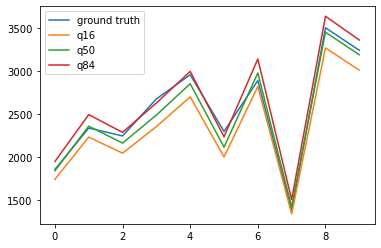

In [18]:
pred = net.predict(z, batch_size=BATCH_SIZE, verbose=0)
idxs = np.random.randint(0, y.shape[0], 10)
plt.plot(y[idxs], label="ground truth")
plt.plot(pred[idxs, 0], label="q16")
plt.plot(pred[idxs, 1], label="q50")
plt.plot(pred[idxs, 2], label="q84")
plt.legend(loc="best")
plt.show()

### PREDICTION

In [19]:
sub_df['FVC'] = pe[:, 1]
sub_df['Confidence'] = (pe[:, 2] - pe[:, 0])
sub_df.head()

,Patient_Week,Age,Sex,SS_NS,SS_ES,Percent,FVC_0,DeltaWeeks,FVC,Confidence
0,ID00419637202311204720264_-12,0.575,1,0,1,0.467912,0.367273,-0.124138,2873.570312,313.254883
1,ID00419637202311204720264_-11,0.575,1,0,1,0.467912,0.367273,-0.117241,2870.947266,313.036133
2,ID00419637202311204720264_-10,0.575,1,0,1,0.467912,0.367273,-0.110345,2868.323975,312.818604
3,ID00419637202311204720264_-9,0.575,1,0,1,0.467912,0.367273,-0.103448,2865.700195,312.601074
4,ID00419637202311204720264_-8,0.575,1,0,1,0.467912,0.367273,-0.0965517,2863.077148,312.383057


In [20]:
sub_df = sub_df[['Patient_Week', 'FVC', 'Confidence']]
sub_df = sub_df.append(sub_df_0, ignore_index = True)

In [21]:
sub_df.to_csv("submission.csv", index=False)